# Diffusion Entropy Analysis 

2021-02-03 - Garland Culbreth, Jacob Baxley, David Lambert.

Center for Nonlinear Science, University of North Texas.  

## Introduction

This notebook includes functions for performing both DEA with stripes and the original DEA without. The functions with stripes were written by G.C. with contribution from J.B. The original (no stripe) DEA function was done by J.B. and D.L., and vectorized by G.C.

This is a major update of the DEA program, using Python. It's loosely based on an older Python conversion of my even older MATLAB version, which was converted by Jacob Baxley, David Lambert, and me. That conversion relied on an old module of legacy code, which was outdated and in need of refinement. For this version, I wrote a completely new function that performs the same process, but faster and using standard Python/NumPy functions.

Useage instructions and documentation etc. can be found in markdown cells or function docstrings.

## Using this notebook

All work should be done in the bottom code cell, the one labeled "Work cell". 

In [218]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from fbm import fbm, fgn
from tqdm import tqdm

In [219]:
plt.style.use('ggplot')  # use any plt.style you like

## Sample data  

Generators for Fractional Brownian Motion and a simple Random Walk, for testing purposes. If you have no data, use these to generate some.

In [220]:
def sample_data(length):
    """Generates an array of sample data."""
    # hurst = 0.7
    # fGnSample = fgn(length, hurst)
    # fBmSample = fbm(length, hurst)
    np.random.seed(0)  # for baseline consistency
    random_steps = np.random.choice([-1, 1], length)
    random_steps[0] = 0  # always start from 0
    random_walk = np.cumsum(random_steps)
    return random_walk

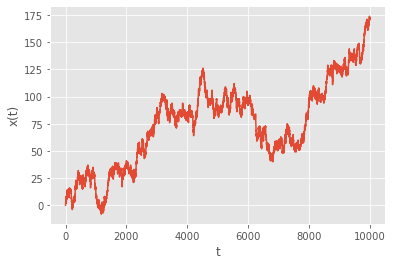

In [221]:
some_data = sample_data(10000)

plt.plot(some_data)
plt.xlabel('t')
plt.ylabel('x(t)')
plt.show()

## Functions  

In [222]:
def apply_stripes(data, stripes, show_plot): 
    """
    Rounds `data` to `stripes` evenly spaced intervals.

    Parameters
    ----------
    data : array_like
        Time-series data to be examined.
    stripes : int
        Number of stripes to apply. 
    show_plot : bool
        If True, show data plot with overlaid stripes.

    Returns
    ----------
    rounded_data : ndarray
        `data` rounded to `stripes` number of equally spaced intervals.
    """
    
    if show_plot == True:
        lines = np.linspace(min(data), max(data), num=stripes)
        plt.figure(figsize=(6, 5))
        plt.plot(data)
        plt.hlines(y=lines, xmin=0, xmax=len(data))
        plt.xlabel('t')
        plt.ylabel('Data(t)')
        plt.title('Data with stripes')
        plt.show()
    
    if min(data) <= 0:
        data = data + abs(min(data))
    elif min(data) > 0:
        data = data - abs(min(data))
    max_data = max(data)
    min_data = min(data)
    data_width = abs(max_data - min_data)
    stripe_size = data_width / stripes
    rounded_data = data / stripe_size
    
    return rounded_data

In [223]:
def find_events(series):
    """Records an event (1) when `series` changes value."""
    events = []
    for i in range(1, len(series)):
        if (series[i] < np.floor(series[i-1])+1 and 
            series[i] > np.ceil(series[i-1])-1):
            # if both true, no crossing
            events.append(0)
        else:
            events.append(1)
    np.append(events, 0)
    return events

In [224]:
def make_trajectory(events):
    """Constructs diffusion trajectory from events."""
    trajectory = np.cumsum(events)
    return trajectory

In [225]:
def entropy(trajectory):
    """
    Calculates the Shannon Entropy of the diffusion trajectory.

    Generates a range of window lengths L. Steps each one along 
    `trajectory` and computes the displacement of `trajectory` 
    over each window position. Bins these displacements, and divides 
    by the sum of all bins to make the probability distribution `p`. 
    Puts `p` into the equation for Shannon Entropy to get s(L).
    Repeats for all L in range `WindowLengths`.

    Parameters
    ----------
    trajectory : array_like
        Diffusion trajectory. Constructed by make_trajectory.

    Returns
    ----------
    s : ndarray
        Shannon Entropy values, S(L).
    window_lengths : ndarray
        Window lengths, L. 

    Notes
    ----------
    `tqdm()` makes the progress bar appear.
    """
    S = []
    window_lengths = np.arange(1, int(0.25*len(trajectory)), 1)
    for L in tqdm(window_lengths):
        window_starts = np.arange(0, len(trajectory)-L, 1)
        window_ends = np.arange(L, len(trajectory), 1)
        displacements = trajectory[window_ends] - trajectory[window_starts]
        bin_counts = np.bincount(displacements)
        bin_counts = bin_counts[bin_counts != 0]
        P = bin_counts / np.sum(bin_counts)
        S.append(-np.sum(P * np.log(P)))
    return S, window_lengths

In [226]:
def no_stripe_entropy(trajectory):
    """
    Calculates the Shannon Entropy of the diffusion trajectory.

    Generates a range of window lengths L. Steps each one along 
    `trajectory` and computes the displacement of `trajectory` 
    over each window position. Bins these displacements, and divides 
    by the sum of all bins to make the probability distribution `p`. 
    Puts `p` into the equation for Shannon Entropy to get s(L).
    Repeats for all L in range `WindowLengths`.

    Parameters
    ----------
    trajectory : array_like
        Diffusion trajectory. FOR NO STRIPES JUST PASS THE DATA SERIES.

    Returns
    ----------
    S : ndarray
        Shannon Entropy values, S(L).
    window_lengths : ndarray
        Window lengths, L.

    Notes
    ----------
    `tqdm()` makes the progress bar appear.
    """
    window_lengths = np.arange(1, int(0.25*len(trajectory)), 1)
    S = []
    for L in tqdm(window_lengths):
        window_starts = np.arange(0, len(trajectory)-L, 1)
        window_ends = np.arange(L, len(trajectory), 1)
        traj = trajectory[window_starts] - trajectory[window_ends]
        counts, bin_edge = np.histogram(traj, bins='doane')  # doane least bad for nongaussian
        counts = np.array(counts[counts != 0])
        binsize = bin_edge[1] - bin_edge[0]
        P = counts / sum(counts)
        S.append(-sum(P*np.log(P)) + np.log(binsize))
    return S, window_lengths

In [227]:
def get_scaling(S, L, start, stop):
    """
    Calculates scaling.
    
    Calculates the scaling of the time-series by performing a 
    least-squares linear fit over S(l) and ln(l).

    Parameters
    ----------
    s : array_like
        Shannon Entropy values. 
    L : array_like
        Window Lengths. 
    start : int
        Index at which to start the fit slice.
    stop : int
        Index at which to stop the fit slice.

    Returns
    ----------
    L_slice : ndarray 
        The slice of window lengths L.
    coefficients : ndarray
        Slope and intercept of the fit. 

    Notes
    ----------
    Least-squares linear fits on log scale data have issues, 
    see doi:10.1371/journal.pone.0085777
    Making a version that uses the `powerlaw` package instead 
    would be better...
    """
    S_slice = S[start:stop]
    L_slice = L[start:stop]
    coefficients = np.polyfit(np.log(L_slice), S_slice, 1)
    return L_slice, coefficients

In [240]:
def get_mu(delta):
    """
    Calculates the mu.

    Parameters
    ----------
    delta : float
        Scaling of the time-series process. 

    Returns
    ----------
    mu : float
        Complexity parameter. Powerlaw index for inter-event 
        time distribution.
    """
    mu = 1 + (1 / delta)
    if mu > 3:
        mu = 1 + delta
    mu1 = 1 + delta
    mu2 = 1 + (1 / delta)
    return mu1, mu2

In [229]:
def plot_results(L, S, x_interval, slope, y_intercept, mu):
    """testing a plotting function"""
    fig, ax = plt.subplots()
    ax.plot(L, S, linestyle='', marker='.')
    ax.plot(x_interval, slope * np.log(x_interval) + y_intercept, color='k',
             label='$\delta = $'+str(np.round(slope, 2)))
    ax.plot([], [], linestyle='',label='$\mu = $'+str(np.round(mu, 2)))
    return ax

In [245]:
def plot_mu_candidates(delta, mu1, mu2):
    x1 = np.arange(1, 2, 0.01)
    x2 = np.arange(2, 3, 0.01)
    x3 = np.arange(3, 4, 0.01)
    y1 = x1 - 1
    y2 = 1 / (x2 - 1)
    y3 = np.full(100, 0.5)

    plt.plot(x1, y1, color='k')
    plt.plot(x2, y2, color='k')
    plt.plot(x3, y3, color='k')
    plt.plot(mu1,
             delta,
             color='#4C72B0',
             marker='o',
             label='$\\mu$ = '+str(np.round(mu1, 2)))
    if delta >= 0.5:
        plt.plot(mu2,
                 delta,
                 color='#C44E52',
                 marker='o',
                 label='$\\mu$ = '+str(np.round(mu2, 2)))  
    plt.xticks(ticks=np.arange(1, 4.1, 0.5))
    plt.yticks(ticks=[0, 0.5, 1])
    plt.xlabel('$\\mu$')
    plt.ylabel('$\\delta$')
    plt.legend(loc=0)

In [231]:
def dea_no_stripes(data, start, stop):
    """
    Applies DEA without the stripes refinement.

    Original DEA. Takes the original time series as the diffusion 
    trajectory.

    Parameters
    ----------
    data : array_like
        Time-series to be analysed.
    start : int
        Array index at which to start linear fit.
    stop : int 
        Array index at which to stop linear fit.

    Returns
    ----------
    figure 
        A figure plotting S(l) vs. ln(l), overlaid with the fit 
        line, labelled with the scaling and mu values.
    """
    S, L = no_stripe_entropy(data)
    fit = get_scaling(S, L, start, stop)
    mu = get_mu(fit[1][0])

    fig = plt.figure(figsize = (6, 5))
    plt.plot(L, S, linestyle='', marker='.')
    plt.plot(fit[0], fit[1][0] * np.log(fit[0]) + fit[1][1], color='k',
             label='$\delta = {}$'.format(np.round(fit[1][0], 2)))
    plt.plot([], [], linestyle='', 
             label='$\mu = {}$'.format(np.round(mu, 2)))
    plt.xscale('log')
    plt.xlabel('$ln(l)$')
    plt.ylabel('$S(l)$')
    plt.legend(loc=0)
    # plt.show()
    return fig

In [232]:
def dea_with_stripes(data, stripes, start, stop, data_plot):
    """
    Applies DEA with the stripes refinement.

    Runs a sequence of functions to apply stripes and then 
    perform DEA on the data series. 

    Parameters
    ----------
    data : array_like
        Time-series to be analysed.
    stripes : int
        Number of stripes to be applied to the data.
    start : int
        Array index at which to start linear fit.
    stop : int 
        Array index at which to stop linear fit.
    data_plot : bool
        If True, show data plot with overlaid stripes.

    Returns
    ----------
    fig : figure 
        A figure plotting S(l) vs. ln(l), overlaid with the fit 
        line, labelled with the scaling and mu values.
    """
    rounded_data = apply_stripes(data, stripes, data_plot)
    event_array = find_events(rounded_data)
    diffusion_trajectory = make_trajectory(event_array)
    s, L = entropy(diffusion_trajectory)
    fit = get_scaling(s, L, start, stop)
    mu = get_mu(fit[1][0])
    check_mus_plot = plot_mu_candidates(fit[1][0], mu[0], mu[1])

    fig = plt.figure(figsize = (6, 5))
    plt.plot(L, s, linestyle='', marker='.')
    plt.plot(fit[0], fit[1][0] * np.log(fit[0]) + fit[1][1], color='k',
             label='$\delta = $'+str(np.round(fit[1][0], 2)))
    plt.xscale('log')
    plt.xlabel('$ln(L)$')
    plt.ylabel('$S(L)$')
    plt.legend(loc=0)
    # plt.show()
    return fig

## Known mu data generating function

In [233]:
def known_mu_test(mu, T):
    test_tau = np.arange(1, 1000, 1)
    distribution = (mu-1) * ((T**(mu-1)) / ((T+test_tau)**mu))
    waiting_times = np.random.choice(distribution, 50000)
    event_indexes = np.ceil(1000*np.cumsum(waiting_times)).astype(int)
    random_walk = np.random.choice([-1, 1], len(waiting_times))
    known_mu_data = np.zeros(max(event_indexes)+1)
    known_mu_data[event_indexes] = random_walk
    # for i in range(1, len(known_mu_data)):
    #     if known_mu_data[i] == 0:
    #         known_mu_data[i] = known_mu_data[i-1]
    # plt.plot(known_mu_data, label='$\\xi$(t)')
    known_mu_data = np.cumsum(known_mu_data)
    return known_mu_data

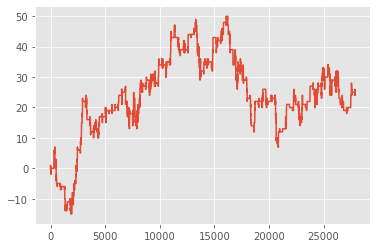

In [234]:
known_mu_sample = known_mu_test(mu=2.3, T=1)
plt.plot(known_mu_sample)
plt.show()

## Work Cell  

Everything you need to work with is in this cell.  

### Running  
 - Load your data into the `data` variable. Numpy arrays or Pandas DataFrame columns will work.  
 - Choose the number of stripes to apply, and the interval (slice) over which to fit.  
 - Run!  
 - Adjust number of stripes and slicing indexes as necessary.  

### Output  
 - A progress bar will display progress and time elapsed/remaining.  
 - On completion, a figure will be drawn with the results.  
 - Interpretation of results has its own section, below.  

### Choosing number of stripes  
 - Run a few initial tests with different values. e.g. 10, 50, 100.  
 - If there is significant disagreement in the scalings measured, vary about those trial numbers.  
 - The correct number of stripes to use is that number such that when varied up or down a little, the scaling does not change.  

### Choosing fit interval  
 - In the result figure, if the results are good, there will be a powerlaw region that in the loglog figure appears linear. You want the fit interval to line up with this region.  
 - $S(l)$ is logged in calculation, $l$ is logged by the scale of the plot. The fitting function accounts for this.  

100%|██████████| 8513/8513 [00:05<00:00, 1464.65it/s]


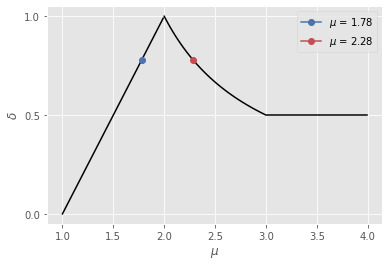

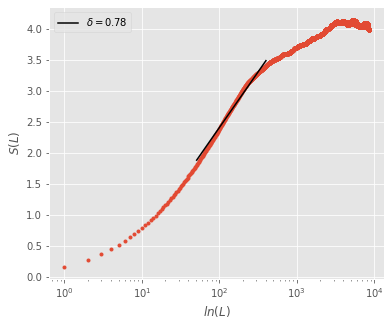

In [244]:
### ----WORK HERE---- ###
# data = known_mu_test(mu=1.8, T=1)
data = sample_data(10000)
number_of_stripes = 40  # needs to be at least 2
fit_start = 50
fit_stop = 400
show_data_plot = False  # make True to see plot of data with stripes

result = dea_with_stripes(data, number_of_stripes, fit_start, fit_stop, show_data_plot)
plt.show()

100%|██████████| 2499/2499 [00:03<00:00, 671.85it/s]


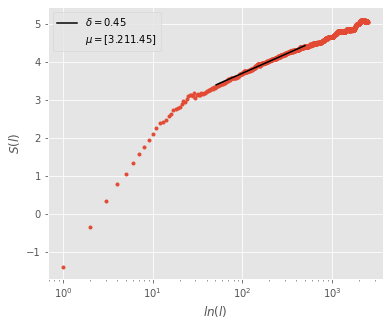

In [236]:
no_dea_result = dea_no_stripes(data, start=50, stop=500)
plt.show()

## Interpreting Results  

### Basics  
 - $\delta$ is the measured scaling of the time-series process.  
 - $\mu$ is a complexity index, defined as the power for the inter-event time distribution $1/\tau^{\mu}$ ($\tau$ being inter-event time).  

### Baselines  
 - For a totally random process, DEA yields $\delta = 0.5.$  
 - The closer $\delta$ is to 1, and the closer $\mu$ is to 2, the more complex the data-series is. Those are the critical values of $\delta$ and $\mu$.  
 - If $\delta < 0.5$, this usually means the time-series is not complex. At least, not in this sense. 

### Determining $\mu$  
 - Two ways of calculating $\mu$ are employed:  
   - For $1 < \mu < 2$: $\mu = 1 + \delta$.  
   - For $2 < \mu < 3$: $\mu = 1 + 1/\delta$.  
 - To choose which calculation is correct, if $\mu = 1 + 1/\delta$ gives a $\mu > 3$ then use $\mu = 1 + \delta$. The program automatically performs this check.
 - This check is only the program's best guess at which $\mu$ formula is the correct one. It does not actually know for sure which region $\mu$ is in, so double check.
 - If you already have an expectation for what range $\mu$ should be in, e.g. from theoretical arguments, use that.
     - See *Overriding $\mu$ calculation* in *Advanced use*.
 - The theoretical justifications for the two methods of deriving $\mu$ from the scaling $\delta$ are given in Section 3.2 of Reference 1 and Section 3.1-3.2 of Reference 3.

## Advanced use


### Speed and runtime
In the function `entropy()` the range of window lengths $l$ is defined such that each is 1 larger than the previous:  
        
        window_lengths = np.arange(1, int(0.25*len(trajectory)), 1)  

This can make the program take a long time to run if you give it a long time-series (e.g. 20000 timesteps takes ~1 second). If you want to speed up the runtime, you can increase the step size for the range, e.g.:

        window_lengths = np.arange(1, int(0.25*len(trajectory)), 10)  

This will still give good results, for long time-series, but can greatly speed up runtime. Akin to taking a subset of the window lengths that would have been used if the step size were 1.  

Doing this also means you will have fewer values of $S(l)$ and $ln(l)$ to work with though, so be mindful.

*I might make this window length step a passable variable in the future, but I'm not sure.*


### Maximum window length
In the function `entropy()` the range of window lengths ends at 0.25 times the length of the diffusion trajectory:

        window_lengths = np.arange(1, int(0.25*len(trajectory)), 10)  

You can increase further if you want, but there is usually no need. For longer window lengths $l$, and especially for $l$ longer than `0.5*len(trajectory)`, $S(l)$ quickly starts to decay and doesn't give anything useful. 


### Overriding $\mu$ calculation
If you have an expectation for what range $\mu$ should be in, e.g. from theoretical arguments, then you can change the function `GetMu()` to just perform the corresponding calculation rather than check a conditional and make a recommendation.

---
## References  
 1. *Entropic Approach to the Detection of Crucial Events* [doi:10.3390/e21020178](https://doi.org/10.3390/e21020178)  
    - This paper introduced the stripes and describes their role with figure examples.
    - Note: this paper used $\eta$ to denote scaling, rather than $\delta$.  
 2. *Scaling detection in time series: Diffusion entropy analysis* [doi:10.1103/PhysRevE.66.036130](https://doi.org/10.1103/PhysRevE.66.036130)  
    - The actual algorithm for DEA is detailed (mostly only in words) in Section IV.  
 3. *Asymmetric anomalous diffusion: an efficient way to detect memory in time series* [doi:10.1142/S0218348X01000865](https://doi.org/10.1142/S0218348X01000865)  
    - This paper introduced always using positive steps when constructing the event array, rather than the sign of the step at that time index.